In [205]:
filename = 'somascan_171_vs_1305.tsv'

In [206]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy import stats
import scipy
import matplotlib.pyplot as plt

In [207]:
df = pd.read_csv(filename, sep='\t')
df_sorted = df.sort_values(by='Age')
df_sorted

,ID,Age,Sex,Cohort,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,...,XPNPEP1,XRCC6,YES1,YWHAB,YWHAB.YWHAE.YWHAG.YWHAH.YWHAQ.YWHAZ.SFN,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
141,41,21,Female,Seattle,"4,298","2,497","2,902","2,793","2,463","3,095",...,"3,61","2,143","2,51","3,812","2,944","3,181","3,072","4,667","3,682","3,551"
126,26,22,Female,Seattle,"4,338","2,185","3,078","2,965","2,445","3,704",...,"4,091","2,353","2,658","4,128","3,218","3,312","2,847","5,02","3,72","2,408"
142,42,22,Female,Seattle,"4,341","2,952","2,897","2,697","2,352","3,222",...,"3,576","2,27","2,534","3,841","2,979","3,232","2,875","4,702","3,761","2,372"
107,7,22,Male,Seattle,"4,155","2,281","3,062","2,743","2,459","3,112",...,"4,213","2,159","2,738","4,382","3,446","3,167","2,958","5,189","3,655","2,466"
115,15,23,Male,Seattle,"4,161","2,576","3,019","2,694","2,47","3,129",...,"4,113","2,181","2,74","4,384","3,475","3,142","2,94","5,222","3,68","2,62"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,11030,105,Male,PRIN09,"3,957","2,25","3,036","2,708","2,469","3,697",...,"4,086","2,344","2,924","4,416","3,636","3,146","3,023","5,15","3,68","2,485"
6,11300,106,Female,PRIN09,"4,142","2,278","3,037","2,77","2,414","3,6",...,"3,455","2,264","2,717","3,866","2,942","3,162","2,871","4,504","3,787","2,471"
3,11140,106,Male,PRIN09,"4,066","2,262","3,131","2,704","3,019","3,517",...,"3,6","2,258","2,692","4,084","3,097","3,133","2,968","4,75","3,747","2,556"
2,11130,106,Female,PRIN09,"4,149","2,199","3,022","2,598","2,508","3,377",...,"4,045","2,172","2,735","4,315","3,389","3,149","3,089","5,133","3,599","2,605"


In [208]:
# Константы
number_of_best_features = 5
number_of_intervals = 5
propotion_of_youngest_and_oldest = 0.15

In [209]:
# Вспомогательные функции
def mean_from_str_values(str_values):
    return np.array(list(map(float, [elem.replace(',', '.') for elem in str_values]))).mean()


def from_str_values(str_values):
    return list(map(float, [elem.replace(',', '.') for elem in str_values]))

# Определение наиболее изменичивых с возрастом признаков
У меня возникло 2 идеи, как можно определить наиболее изменичивые с возрастом признаки.

Способ 1: Чтобы определить как меняется признак с возрастом - отберем несколько (15%) самых молодых людей и самых старших, а дальше посмотрим на разность средних значений. Этот метод неплох тем, что он устойчив к выбросам между 2 ближайшими по возрасту людьми.

Способ 2: Обычно, когда мы хотим определить общую тенденцию точечной функции - мы хотим построить какое-то приближение (по которому уже легко понять общую тенденцию). Так давайте построим линейное приближение, а затем будем сравнивать коэффициенты наклонов прямых.

В обоих случаях будем использовать нормализацию (описано дальше).

In [210]:
# Реализация первого способа.
def determine_best_features_variant_1():
    # Выбор по 15% самых старых и молодых пациентов.
    amount_of_youngest_and_oldest = int(len(df['Age']) * propotion_of_youngest_and_oldest)
    df_young = df_sorted[:amount_of_youngest_and_oldest]
    df_old = df_sorted[len(df['Age']) - amount_of_youngest_and_oldest:]
    features_difference = list()
    for i in range(4, len(df_old.columns)):
        # Считаем модуль разницы средних значений показателей
        abs_difference = abs(mean_from_str_values(df_old.iloc[:, i].values) 
                             - mean_from_str_values(df_young.iloc[:, i].values))
        
        # Коэффициент нормализации - сумма средних значение.
        abs_value = mean_from_str_values(df_old.iloc[:, i].values) 
        + mean_from_str_values(df_young.iloc[:, i].values)
        features_difference += [[abs_difference / abs_value, df_old.iloc[:, [i]].columns[0]]]
        
    # Сортировка и выбор 5 лучших.
    best_features = [elem[1] for elem in sorted(features_difference)[len(features_difference) - number_of_best_features: len(features_difference)]]
    print(best_features)
    return best_features

In [211]:
# Реализация второго способа
def determine_best_features_variant_2():
    # Отберем нужные столбцы.
    x = df_sorted['Age'].values
    y = [[df_sorted[elem].values, elem] for elem in df_sorted][4:]
    
    # Приблизим линейной функций с помощью MSE и возьмем коэффициент нормализаванный коэффиуиент наклона, чтобы
    # отразить именно относительное изменение, а не абсолютное. В качестве коэффициента нормализации я взял
    # среднее значение показателя.
    normalize = [np.array(from_str_values(elem[0])).mean() for elem in y]
    
    # Сортировка и выбор 5 лучших.
    best_features = [[abs(np.polyfit(x, from_str_values(y[i][0]), 1)[0] / normalize[i]), y[i][1]] for i in range(len(y))]
    best_features = sorted(best_features)[len(best_features) - number_of_best_features:len(best_features)]
    best_features = [elem[1] for elem in best_features]
    print(best_features)
    return best_features

# Построение графиков
Графики зависимоти показателей от возраста как и сказано в задании построены в виде ломанной. Для сравнения значений на интервалах и отображения p-value между интервалами я предпочел гистограммы, потому что они наилучшим образом относительные значения, так как в отличии от первого графика у нас всего несколько точек.

In [280]:
def show_plot(title, xlabel, ylabel, x_data, y_data, feature_num, age_intervals, mean_interval_value, p_value):
    # Первый график
    plt.figure(figsize=(16, 4))
    plt.tight_layout()
    plt.subplot(1, 3, 1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_data, y_data, color = 'y')
    
    # Второй график
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Значение на интервале по возрасту")
    ax.set_xlabel("Возрастные интервалы")
    x_bar = [str(interval[0]) + "-" + str(interval[1]) for interval in age_intervals]
    ax.bar(x_bar, mean_interval_value[feature_num], color = 'r')
    
    # Третий график
    p_value_diagram = plt.subplot(1, 3, 3)
    p_value_diagram.set_title("p-value для ревенства средних значений интервалов")
    p_value_diagram.set_xlabel("Интервалы")
    x_bar = ['1-2', '2-3', '3-4', '4-5']
    p_value_diagram.bar(x_bar, p_value, color = 'b')
    plt.show()

# Решение
Тут не слишком интересно, взял количество интервалов, равное 5, дальше посчитал среднее значение на возрастных интервалах, а так же рассчитал p-value между соседними интервалами и отрисовал графики.

In [281]:
def solve(best_features):
    number_of_samples = int(len(df) / number_of_intervals)
    
    # Конвертация значений
    str_intervals = [df_sorted[best_features]
             [i * number_of_samples:(i + 1) * number_of_samples] for i in range(number_of_intervals)]
    float_intervals = [[from_str_values(str_intervals[i].values[j]) for j in range(number_of_samples)]
                   for i in range(number_of_intervals)]
    # critial_p_value = 0.1
    
    x_data = df_sorted['Age'].values
    y_data = [from_str_values(df_sorted[feature].values) for feature in best_features]
    
    # Вычисление средних значений показателей на интервалах и возрастные границы интервалов
    mean_interval_value = [[pd.DataFrame(float_intervals[i])[j].mean()
                        for i in range(len(best_features))]for j in range(number_of_intervals)]
    interval_bounds = [(df_sorted['Age'].values[i * number_of_samples],
                    df_sorted['Age'].values[(i + 1) * number_of_samples - 1]) for i in range(number_of_intervals)]
    p_value_between_intervals = [[stats.ttest_ind(float_intervals[i], float_intervals[i + 1]).pvalue[j]
                              for i in range(number_of_intervals - 1)] for j in range(len(best_features))]
    # Отрисовка
    for i in range(len(best_features)):
        show_plot("Признак " + best_features[i], "Возраст", "Значение",
              x_data, y_data[i], i, interval_bounds, mean_interval_value, p_value_between_intervals[i])

In [282]:
best_features = determine_best_features_variant_1()

['CGA.FSHB', 'NPPB.1', 'CKB.CKM', 'OLFM4', 'MMP3']


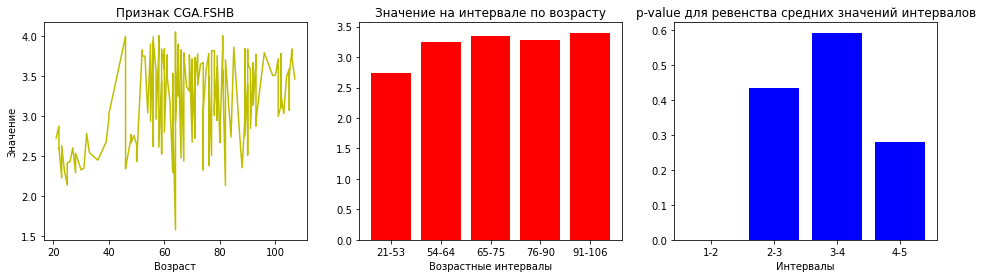

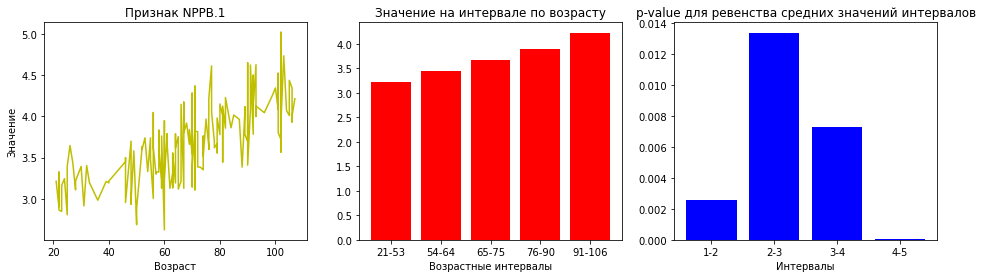

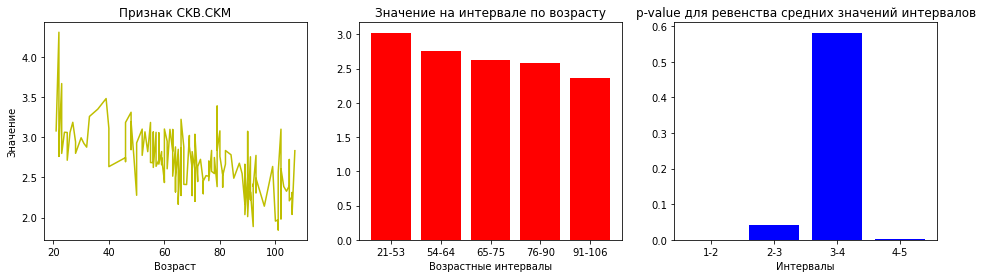

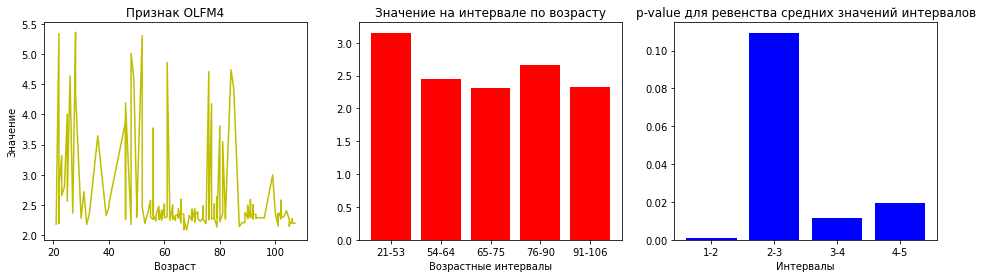

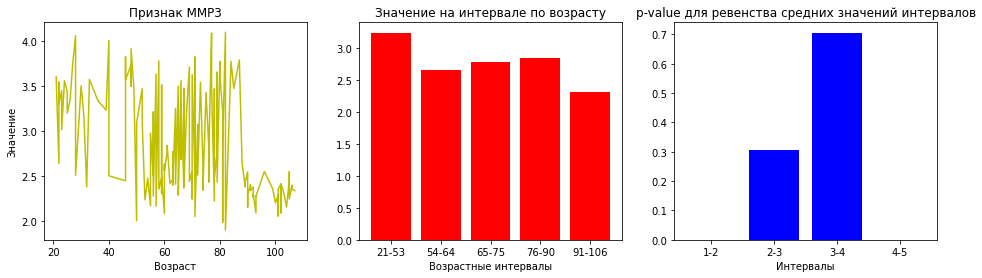

In [283]:
solve(best_features)

In [284]:
best_features = determine_best_features_variant_2()

['CHI3L1', 'CKB.CKM', 'OLFM4', 'NPPB.1', 'MMP3']


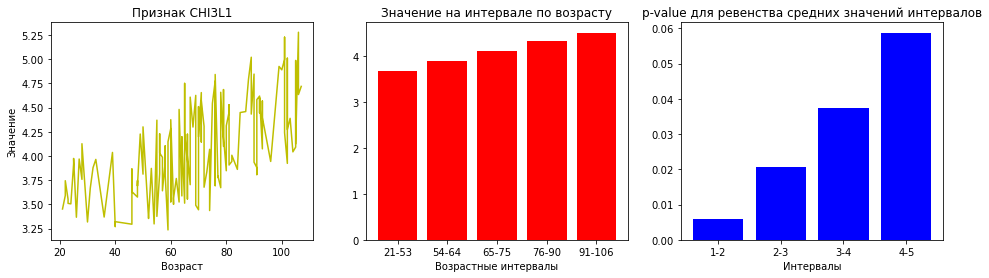

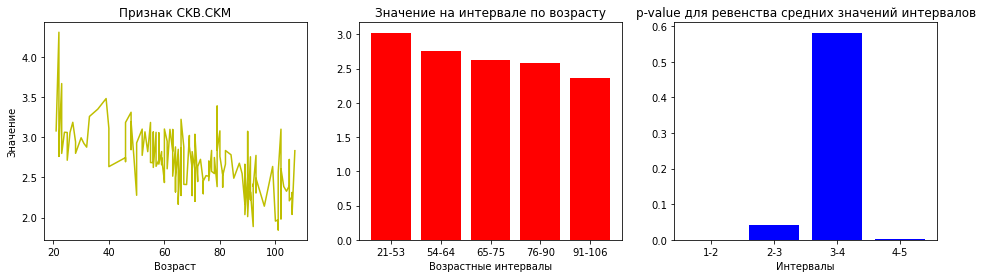

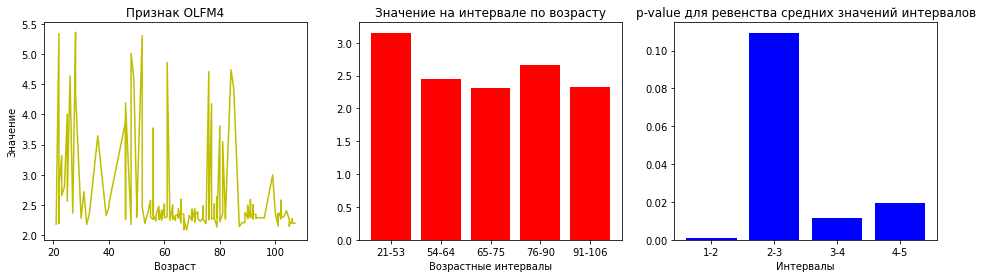

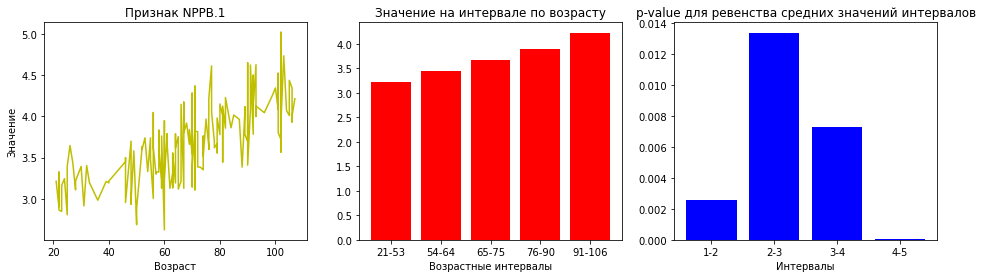

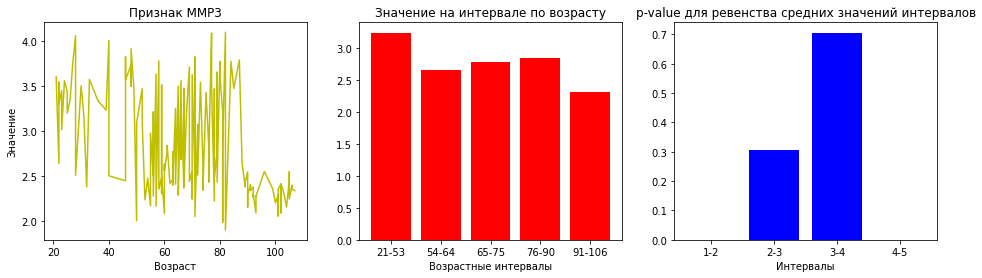

In [285]:
solve(best_features)

# Итоги
Интересно, что 4 из 5 признаков были выбраны как наиболее изменчиные с возрастом - двумя различными метода, что говорит нам о том, что определение получилось достаточно точным.

По графикам, которые отражают среднее значения показателя на интервале можно сделать вывод, что показтель действительно изменяется с возрастом, а по графикам, отражающим p-value - что чаще всего это происходит не случайно. Хотя есть и показатели, для которых p-value переваливает за критическое значение, равное 0.01, между большинством интервалов.